In [1]:
import json
import pandas as pd
from datetime import datetime,timedelta
from skyfield.api import EarthSatellite,load, wgs84
import math
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as scio


In [2]:
# events=pd.read_csv('./conjunction_event_1km_maneuver.csv') #之前的版本,没有筛选出尖峰
events=pd.read_csv('./data/conjunction_event_brust_maneuver.csv')
events['tca_time']=events['tca_time'].astype('datetime64[ns]')
pc_events=events['max_prob']
miss_dis_event=events['min_rng_km']
starttime=datetime.strptime("2022-4-14 0:0:0","%Y-%m-%d %H:%M:%S")
stk_pc_path1='./data/stk_pc2/'
# 3是限制了report时间的,所以确实很多event, 4解除了限制
stk_pc_path2='./data/stk_pc4/'

In [9]:
pc_stk2=[]
md_stk2=[]
for row in tqdm(events.itertuples()):
    try:
        filename=stk_pc_path2+row.ID+'-'+str(row.tca_time).split('.')[0].replace(':','_')+'.mat'
        stk_data=scio.loadmat(filename)
        
        stk_events=pd.DataFrame(columns=['tca','min_range','pc'])
        
        for i in range(len(stk_data['cat_data'][0][0][0][0][1])):
            
            tca=starttime+timedelta(seconds=stk_data['cat_data'][0][0][0][0][1][i][0])
            pc=stk_data['cat_data'][0][0][0][8][1][i][0]
            min_range=stk_data['cat_data'][0][0][0][1][1][i][0]/1000
            stk_events=stk_events.append({'tca':tca,'min_range':min_range,'pc':pc},ignore_index=True)
        # stk_events['delta']=stk_events.apply(lambda x: (x['tca']-row.tca_time).seconds,axis=1)
        # stk_events=stk_events.sort_values(by='delta') #按照与tca_time相差的时间排序
        stk_events=stk_events.sort_values(by='min_range')#按照最小距离排序
        stk_events=stk_events[(stk_events['tca']<row.tca_time+timedelta(days=7))&(stk_events['tca']>row.tca_time-timedelta(days=2))]
        stk_events=stk_events.reset_index()
        stk_event=stk_events.loc[stk_events.index[0]]
        pc_stk2.append(stk_event['pc'])
        md_stk2.append(stk_event['min_range'])
    except Exception as e:
        # print(e)
        pc_stk2.append(0)
        md_stk2.append(0)
        

0it [00:00, ?it/s]/var/folders/8c/lhywgg_15jz7c8cs4r3cn1wr0000gn/T/ipykernel_79278/614583817.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stk_events=stk_events.append({'tca':tca,'min_range':min_range,'pc':pc},ignore_index=True)
/var/folders/8c/lhywgg_15jz7c8cs4r3cn1wr0000gn/T/ipykernel_79278/614583817.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stk_events=stk_events.append({'tca':tca,'min_range':min_range,'pc':pc},ignore_index=True)
/var/folders/8c/lhywgg_15jz7c8cs4r3cn1wr0000gn/T/ipykernel_79278/614583817.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stk_events=stk_events.append({'tca':tca,'min_range':min_range,'pc':pc},ignore_index=True)
/var/folders/8c/lhywgg_15jz7c8cs4r3cn1wr0000gn/T/ipykernel_79

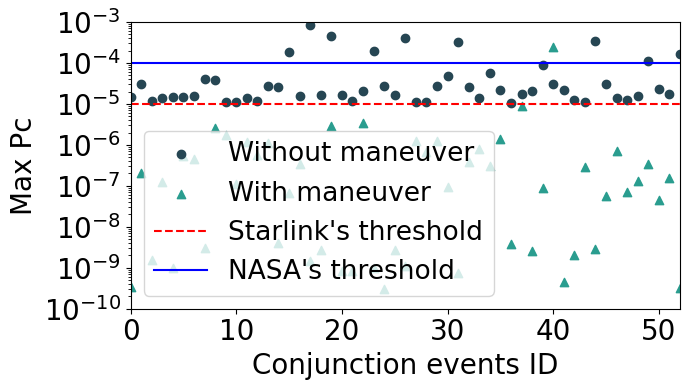

In [10]:
c=['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51',"#3F72AF","#112D4E"]

pc_events_plot=[]
pc_stk2_plot=[]
fs=20
for i in range(len(pc_stk2)):
    if pc_stk2[i]!=0:
        pc_events_plot.append(pc_events[i])
        pc_stk2_plot.append(pc_stk2[i])
        
plt.figure(figsize=(7,4))
plt.axes(yscale = "log")
plt.ylim(1e-10,1e-3)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.scatter(range(len(pc_events_plot)),pc_events_plot,label='Without maneuver',marker='o',c=c[0])
# plt.plot(pc_stk,label='max pc before maneuver')
plt.scatter(range(len(pc_events_plot)),pc_stk2_plot,label='With maneuver',marker='^',c=c[1])
plt.xlim(0,len(pc_stk2_plot)-1)
threshold=[1e-5 for i in range(len(pc_stk2))]
plt.plot(threshold,label='Starlink\'s threshold',linestyle='--',color='red')
threshold=[1e-4 for i in range(len(pc_stk2))]
plt.plot(threshold,label='NASA\'s threshold',linestyle='-',color='Blue')
plt.ylabel('Max Pc',fontsize=fs)

plt.xlabel('Conjunction events ID',fontsize=fs)
plt.legend(fontsize=fs-1,loc='lower left')
plt.tight_layout()
plt.savefig('maneuver-effectiveness-pc-v4.pdf')



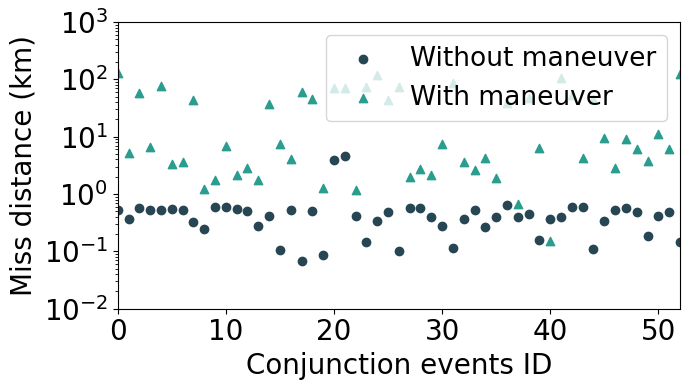

In [11]:
c=['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51',"#3F72AF","#112D4E"]
miss_dis_event_plot=[]
md_stk2_plot=[]
fs=20
for i in range(len(pc_stk2)):
    if pc_stk2[i]!=0:
        miss_dis_event_plot.append(miss_dis_event[i])
        md_stk2_plot.append(md_stk2[i])
        
plt.figure(figsize=(7,4))
plt.axes(yscale = "log")
plt.ylim(1e-2,1e3)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.scatter(range(len(miss_dis_event_plot)),miss_dis_event_plot,label='Without maneuver',marker='o',c=c[0])
# plt.plot(pc_stk,label='max pc before maneuver')
plt.scatter(range(len(md_stk2_plot)),md_stk2_plot,label='With maneuver',marker='^',c=c[1])
plt.xlim(0,len(md_stk2_plot)-1)
# threshold=[1e-5 for i in range(len(pc_stk2))]
# plt.plot(threshold,label='Threshold',linestyle='--',color='red')
plt.ylabel('Miss distance (km)',fontsize=fs)

plt.xlabel('Conjunction events ID',fontsize=fs)
plt.legend(fontsize=fs-1)
plt.tight_layout()
plt.savefig('maneuver-effectiveness-miss-distance-v3.pdf')


### 论文中的统计数据!

In [12]:
temp=[]
for i in range(len(md_stk2_plot)):
    temp.append(md_stk2_plot[i]-miss_dis_event_plot[i])
np.mean(temp)

28.438386361705255